## TORA (benchmark 9)

In [17]:
using Revise, NeuralNetworkAnalysis, JLD2, Plots
const NNA = NeuralNetworkAnalysis
const RA = ReachabilityAnalysis

using NeuralNetworkAnalysis: _forward_network

In [3]:
@load "/home/mforets/.julia/dev/NeuralNetworkAnalysis/models/Sherlock-Benchmark-9/controller9.jld2" controller

1-element Array{Symbol,1}:
 :controller

In [4]:
@taylorize function benchmark9!(dx, x, p, t)
    x₁, x₂, x₃, x₄, u = x

    aux = 0.1 * sin(x₃)
    dx[1] = x₂
    dx[2] = -x₁ + aux
    dx[3] = x₄
    dx[4] = u
    dx[5] = zero(u)
end

In [96]:
X₀ = Hyperrectangle(low=[0.6, -0.7, -0.4, 0.5], high=[0.7, -0.6, -0.3, 0.6])

U₀ = Universe(1)
prob = @ivp(x' = benchmark9!(x), dim: 5, x(0) ∈ X₀ × U₀)
vars_idx = Dict(:state_vars=>1:4, :input_vars=>[], :control_vars=>[5]);

In [101]:
plant = ControlledPlant(prob, controller, vars_idx);
alg = TMJets(abs_tol=1e-9, orderT=8, orderQ=1)
solver = ZonotopeBounder()

@time soltot = solve(plant, T=5.0, Tsample=1.0, alg_nn=solver, alg=alg)
soltotz = overapproximate(soltot, Zonotope);

  1.709608 seconds (28.17 M allocations: 1.850 GiB, 28.31% gc time)


In [102]:
length(soltotz)

5

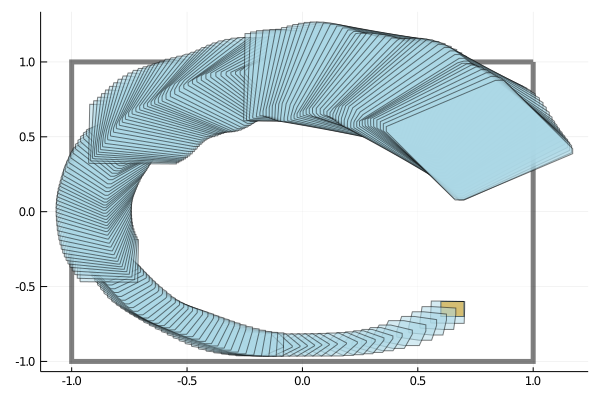

In [103]:
plot(BallInf(zeros(2), 1.0), vars=(1, 2), color=:white, linecolor=:black, lw=5.0)

plot!(LazySets.Projection(X₀, [1, 2]), alpha=1., color=:orange)
plot!(soltotz, vars=(1, 2), color=:lightblue)

In [ ]:
#plot(BallInf(zeros(2), 1.0), vars=(1, 2), color=:white, linecolor=:black, lw=5.0)

plot(solz[end-1][end], vars=(1, 2), color=:lightblue)
plot!(solz[end][1], vars=(1, 2), color=:lightblue)

In [ ]:
plot(solz, vars=(0, 1), color=:lightblue, lw=0.1)
plot(solz, vars=(0, 4), color=:lightblue, lw=0.1)

In [ ]:
solver = MaxSens(tight=true)
U₀ = forward_network(solver, controller, X₀)
U₀ = convert(Interval, U₀)

In [ ]:
solver = BaB(ϵ=5.0)
NNA._forward_network(solver, controller, X₀)
U₀ = convert(Interval, U₀)

In [ ]:
solver = ZonotopeBounder()
U₀ = _forward_network(solver, controller, X₀)
U₀ = convert(Interval, U₀)

## Splitting by hand

In [ ]:
H = overapproximate(set(solz[3][end]), Hyperrectangle)
Hs = split(H, [3, 3, 3, 3, 1]);
alg = TMJets(abs_tol=1e-9, orderT=8, orderQ=1)

# without split
@time sol4 = solve(IVP(prob.s, H), T=1.0, alg=alg)
sol4z = overapproximate(sol4, Zonotope);

# with split
@time sol4s = solve(IVP(prob.s, Hs), T=1.0, alg=alg)
sol4zs = overapproximate(sol4s, Zonotope);

In [ ]:
#all([!isdisjoint(Hsi, Z, algorithm="exact") for Hsi in Hs])

In [ ]:
Z = set(solz[3][end])
H = overapproximate(Z, Hyperrectangle)
Hs = split(H, [6,6,1,1,1]);

plot(LazySets.Projection(H, [1, 2]), alpha=.1, lab="H")
plot!([LazySets.Projection(Hsi, [1, 2]) for Hsi in Hs],alpha=.1, lab="")
plot!(LazySets.Projection(Z, [1, 2]), lab="Z")

## Solving each segment separately

In [91]:
# data
solver = ZonotopeBounder()

X₀ = Hyperrectangle(low=[0.6, -0.7, -0.4, 0.5], high=[0.7, -0.6, -0.3, 0.6])
U₀ = Universe(1)
ivp = @ivp(x' = benchmark9!(x), dim: 5, x(0) ∈ X₀ × U₀)
vars_idx = Dict(:state_vars=>1:4, :input_vars=>[], :control_vars=>[5]);
cpost = TMJets(abs_tol=1e-9, orderT=8, orderQ=1)
S = ivp.s
Q₀ = initial_state(ivp)
sampling_time = 1.0
ti = 0.0
time_span = 0 .. 1.0
st_vars = vars_idx[:state_vars]
network = controller;

In [92]:
# solve first interval
@time begin
    X₀ = LazySets.Projection(Q₀, st_vars)
    P₀ = X₀
    U₀ = NNA._forward_network(solver, network, X₀)
    Q₀ = P₀ × U₀
    dt = ti .. (ti + sampling_time)
    sol = ReachabilityAnalysis.post(cpost, IVP(S, Q₀), dt);
    solz = overapproximate(sol, Zonotope);
end;
soltot = Vector{typeof(solz)}();
push!(soltot, solz);

  0.232592 seconds (3.32 M allocations: 223.032 MiB, 31.33% gc time)


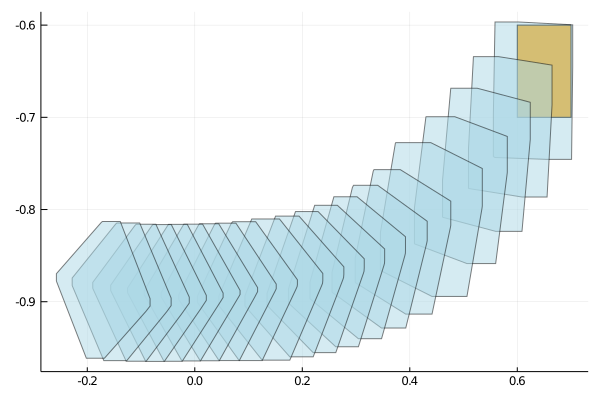

In [12]:
plot(LazySets.Projection(X₀, [1, 2]), alpha=1., color=:orange)
plot!(solz, vars=(1, 2), color=:lightblue)

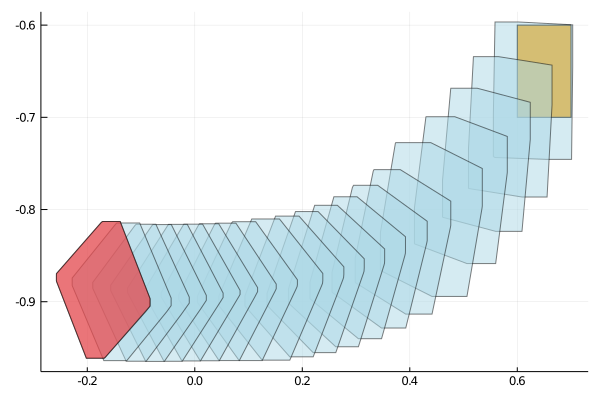

In [13]:
plot!(solz[end], vars=(1, 2) , color=:red)

In [48]:
ngens(set(solz[end]))

10

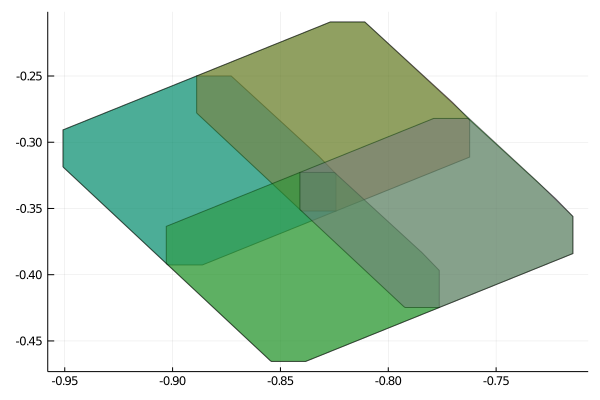

In [64]:
Z = set(solz[end])
#Zr = RA._reduce_order(Z, 1);
Zrs = RA._split(Z, [1, 2], [1, 1])

plot([LazySets.Projection(Zrsi, [1, 2]) for Zrsi in Zrs], alpha=.5)
#plot(LazySets.Projection(Zrs[4], [1, 2]), alpha=.5)
plot!(LazySets.Projection(Z, [1, 2]), alpha=.4, color=:green)

In [93]:
# solve second interval
@time begin
    Z = soltot[end][end]
    X₀ = ReachabilityAnalysis.project(Z, vars=st_vars) |> set
    X₀s = RA._split(X₀, [1, 2], [1, 1])
    U₀ = NNA._forward_network(solver, network, X₀)
    Q₀ = [X₀i × U₀ for X₀i in X₀s]
    ti += sampling_time
    dt = ti .. (ti + sampling_time)
    
    sol = ReachabilityAnalysis.solve(IVP(S, Q₀), tspan=dt, alg=cpost);
    solz = overapproximate(sol, Zonotope);
end;
#push!(soltot, solz);

  0.987704 seconds (17.29 M allocations: 1.131 GiB, 27.35% gc time)


In [107]:
ConvexHullArray([set(fp[end]) for fp in flowpipe(solz)]);

In [111]:
X = ReachabilityAnalysis.project(soltotz[2][end], vars=st_vars)
overapproximate(NNA._forward_network(solver, network, set(X)), Interval)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([1.1464, 2.07316])

In [129]:
Xarr = [ReachabilityAnalysis.project(fp[end], vars=st_vars) for fp in flowpipe(solz)]
T = [overapproximate(NNA._forward_network(solver, network, set(Xi)), Interval) for Xi in Xarr];
overapproximate(ConvexHullArray(T), Interval)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([1.15847, 2.06396])

Interval{Float64,IntervalArithmetic.Interval{Float64}}([1.15847, 2.06396])

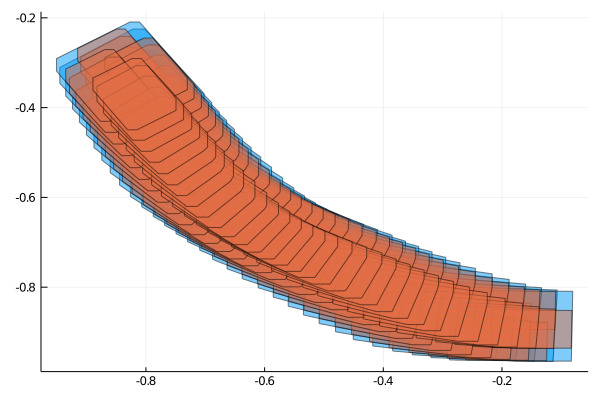

In [100]:
plot(soltotz[2], vars=(1, 2))
plot!(solz, vars=(1, 2))

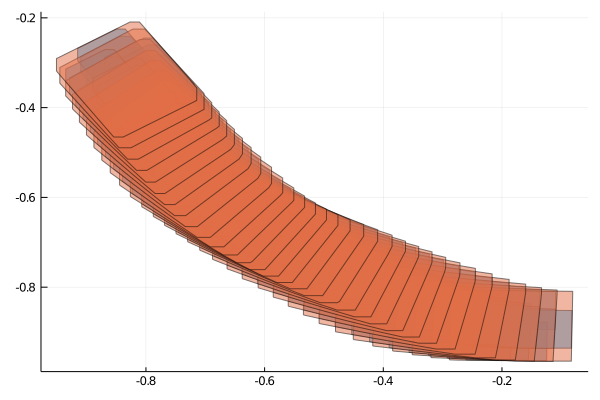

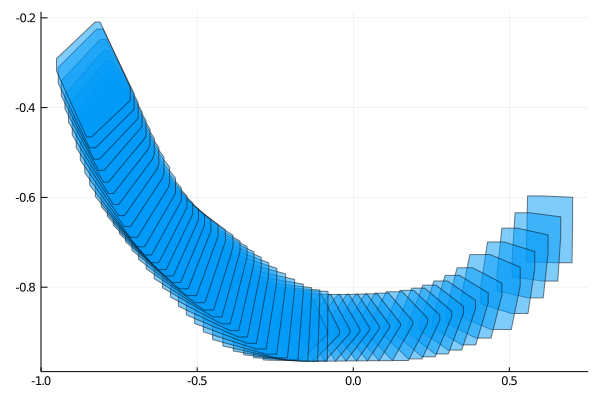

In [45]:
plot(MixedFlowpipe(soltot), vars=(1, 2))